# <font  color = "#0093AF"> Overhauser Effect

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter4/Ch4_OverHauserEffect.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The Overhauser effect is the original DNP experiment, demonstrated on a conducting metal, and commonly used in solution-state DNP. However, it is also possible to obtain the Overhauser effect from non-conducting electrons such as in Trityl or BDPA. In this case, the effect comes from either modulation of the isotropic or dipolar part of the Hyperfine coupling

## Setup

In [0]:
# SETUP SLEEPY

In [2]:
import SLEEPY as sl
from SLEEPY.LFrf import LFrf
import numpy as np
import matplotlib.pyplot as plt

## Example 1: Modulation of the Isotropic Hyperfine (J)

In the first example, we include a scalar and dipolar component to the coupling. However, we only modulate the scalar part. This is achieved by adding different "Aiso" to ex0 and ex1. The two Hamiltonians are then coupled together with the exchange matrix produced by `sl.Tools.twoSite_kex`, where `tc` specifies the correlation time resulting from the exchange matrix.

Increasing the change between `Aiso` and `Aiso1` will accelerate the transfer. Modifying `tc` will also change the rate, although the current value (1 ps) is nearly optimum.

### Build the system

In [6]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30)
ex0.set_inter('g',i=1,gxx=2.0027,gyy=2.0031,gzz=2.0034)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1)

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

### Propagate and plot

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

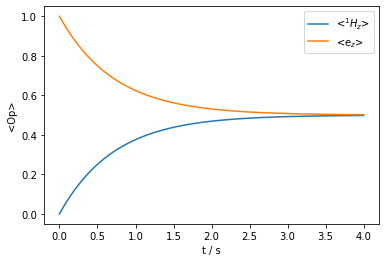

In [7]:
seq=L.Sequence()
rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
rho.plot(axis='s')

Observe that the relaxation is a pure transfer from modulation of the isotropic part of the hyperfine coupling. No magnetization is lost.

## Example 2: Reorientation of the Dipolar Hyperfine
In the second example, we leave the isotropic component fixed, and reorient the dipolar component of the hyperfine coupling.

### Edit the interactions

In [ ]:
ex1.set_inter('hyperfine',i0=0,i1=1,
              Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0,
              euler=[0,np.pi/4,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

### Propagate and plot

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

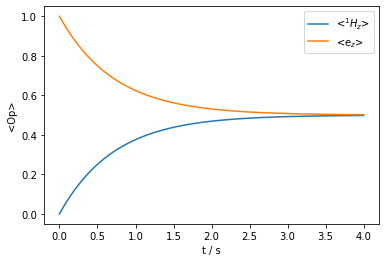

In [8]:
seq=L.Sequence()
rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
rho.plot(axis='s')

We see sharp contrasts between the two Overhauser effect mechanisms. When the scalar coupling is modulated, the total magnetization is conserved: it is simply transferred between the electron and nucleus until the magnetization is equilibrated. On the other hand, reorientation of the dipolar component both transfers magnetization between electron and nucleus, but also gradually destroys the total magnetization. We also notice that the sign of the transfer changes. We can simulate both mechanisms simultaneously (we reduce the size of the dipolar modulation to make the two effects occur on a similar timescale).

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

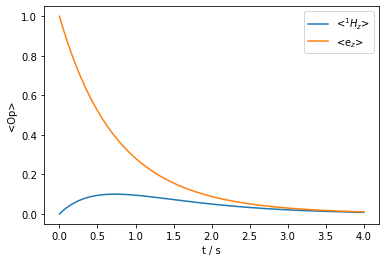

In [9]:
ex1.set_inter('hyperfine',i0=0,i1=1,
              Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1,
              euler=[0,np.pi/16,0])
L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

seq=L.Sequence()
rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
rho.plot(axis='s')

Then, the sign of the transfer turns positive, indicating the scalar mechanism, but the dipolar mechanism is also present and gradually destroys the magnetization. Note that in the real experiment, we would have a *much* faster electron relaxation, which would effectively decouple it from the $^1$H relaxation. However, if the electron is saturated, then during it's recovery, the $^1$H would become polarized. We demonstrate this effect next.

## Example 3: Overhauser Effect buildup with Saturating field

This last calculation requires a few special features of SLEEPY, because the Overhauser effect only occurs in the lab frame, so we must also irradiate the electron in the lab frame. It also requires recovery to thermal equilibrium, which is implemented differently under dynamic conditions than if using explicit $T_1$ (non-Lindblad implementation).

Some caution should be taken with the 'DynamicThermal' method (see [$T_1$ tests](Chapter2/Ch2_T1_limits.ipynb)). We check here first that thermal equilibrium is obtained correctly for this system, before we apply microwave irradiation to the electron.

### Build the system

In [14]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30,pwdavg=sl.PowderAvg(q=2)[10],T_K=80)
ex0.set_inter('g',i=1,gxx=2.0027,gyy=2.0031,gzz=2.0034)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1,euler=[0,np.pi/8,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)
L.add_relax('DynamicThermal')

gavg=(2.0027+2.0031+2.0034)/3
ge=sl.Constants['ge']

### Propagate without microwaves

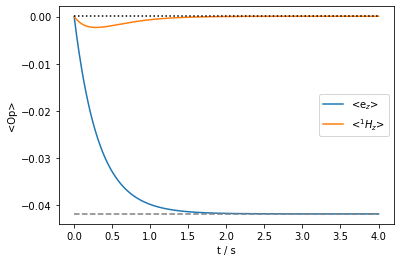

In [13]:
seq=L.Sequence()
rho=sl.Rho('zero',['ez','1Hz'])
rho.DetProp(seq,n=20000)
ax=rho.plot(axis='s')
ax.plot(rho.t_axis[[0,-1]],np.ones(2)*ex0.Peq[0],color='black',linestyle=':')
ax.plot(rho.t_axis[[0,-1]],np.ones(2)*ex0.Peq[1],color='grey',linestyle='--')

We get good performance here from the 'DynamicThermal' method. Now we observe the Overhauser effect enhancement by irradiating the electron such that it saturates, driving enhancement on the $^1$H

### Lab frame irradiation

In [15]:
seq=L.Sequence().add_channel('e',v1=5e6,voff=ex0.v0[1]*(gavg-ge)/ge)  #10 MHz irradiating field
U=LFrf(seq).U()

LF calculation: |██████████████████████████████| 100% complete
Completed


### Propagate and plot

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

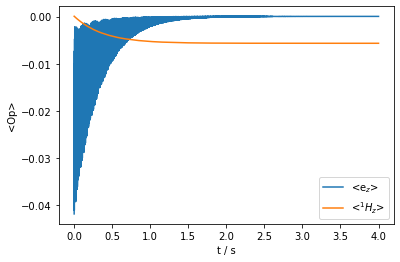

In [40]:
rho=sl.Rho('Thermal',['ez','1Hz'])
# This extracts the final polarization
# normalize to thermal polarization
e=(U**np.inf*rho)().I[1,0].real/ex0.Peq[0]

# Clear, run the buildup
rho.clear()
rho.DetProp(U,n=20000)
rho.plot(axis='s')

In [41]:
print(f'Enhancement: {e:.0f}')

Enhancement: -89


Now, we attempt to extract the $^1$H T$_1$ and transfer rate, $\Gamma_{IS}$, and use these rates to predict the enhancement and compare to our result

### Predict enhancement from rate constants

In [43]:
L.clear_relax()

U=L.U()

rho=sl.Rho('1Hz','1Hz')
rho.DetProp(U,n=200)

R1H=(rho.I[0][0]-rho.I[0][1]).real/rho.t_axis[1]

rho=sl.Rho('ez','1Hz')
rho.DetProp(U,n=200)

Gamma=-rho.I[0][1].real/rho.t_axis[1]

print(f'Predicted Enhancement : {Gamma/R1H*sl.Tools.NucInfo("e")/sl.Tools.NucInfo("1H"):.1f}')

Predicted Enhancement : -90.5


Indeed, the enhancment is well-predicted from rate constants, suggesting also that the simulation is correctly constructed. Finally, we re-run the simulation with a powder average (and also a more realistic power level).

### Include powder average

LF calculation: |██████████████████████████████| 100% complete
Completed


<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

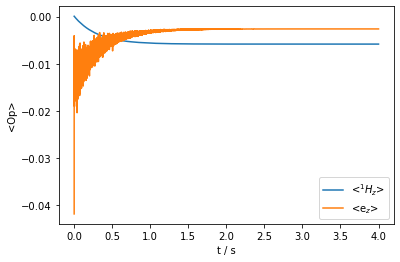

In [44]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30,T_K=80,pwdavg=sl.PowderAvg(q=2))
ex0.set_inter('g',i=1,gxx=2.0027,gyy=2.0031,gzz=2.0034)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1,euler=[0,np.pi/8,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)
L.add_relax('DynamicThermal')

gavg=(2.0027+2.0031+2.0034)/3
ge=sl.Constants['ge']

seq=L.Sequence().add_channel('e',v1=5e6,voff=ex0.v0[1]*(gavg-ge)/ge)  #1 MHz irradiating field

U=LFrf(seq).U()

rho=sl.Rho('Thermal',['1Hz','ez'])

rho.DetProp(U,n=20000)

rho.plot(axis='s')

In [45]:
print(f'Enhancement: {rho.I[0][-1].real/ex0.Peq[0]:.1f}')

Enhancement: -91.9


### Predicted enhancement

In [46]:
L.clear_relax()

U=L.U()

rho=sl.Rho('1Hz','1Hz')
rho.DetProp(U,n=200)

R1H=(rho.I[0][0]-rho.I[0][1]).real/rho.t_axis[1]

rho=sl.Rho('ez','1Hz')
rho.DetProp(U,n=200)

Gamma=-rho.I[0][1].real/rho.t_axis[1]

print(f'Predicted Enhancement : {Gamma/R1H*sl.Tools.NucInfo("e")/sl.Tools.NucInfo("1H"):.1f}')

Predicted Enhancement : -93.0
